# LAB3

In this lab we are tasked with exploring various local-search algorithm to solve a black-box problem in the minimum number of fitness calls.

In [3]:
from random import choices, sample, random, randint, choice
from math import exp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import lab9_lib

### Evolutionary Algorithm
Let's start with an Evolutionary Algorithm, to avoid wasting calls we use an implementation of the $\mu + \lambda$ selection method, we also impose the coexistence of crossover and mutation (we defined them as mutually exclusive in the previous lab).
We expect poor results overall given the randomic nature of the algorithm. 

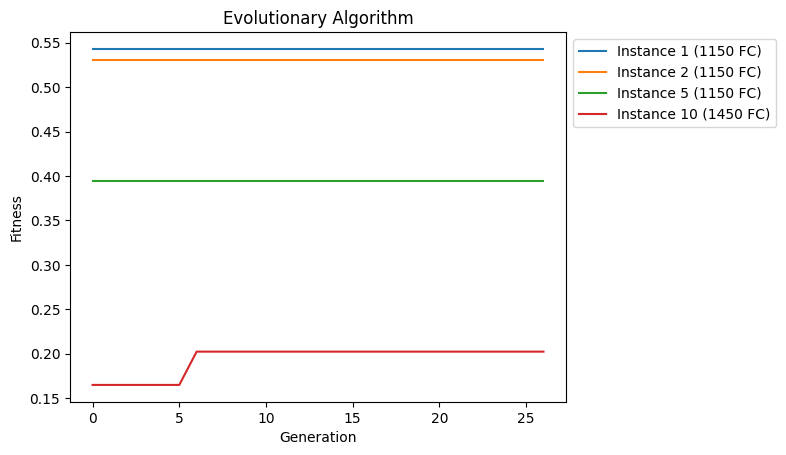

In [4]:
p_1 = lab9_lib.make_problem(1)
p_2 = lab9_lib.make_problem(2)
p_5 = lab9_lib.make_problem(5)
p_10 = lab9_lib.make_problem(10)

NUM_LOCI = 1000

class Individual:
    def __init__(self, genome):
        self.genome = genome
        self.fitness = None

    def evaluate(self, fitness):
        if self.fitness is None:
            self.fitness = fitness(self.genome)
        return self.fitness
    
    def gen_to_int(self, split_size):
        if len(self.genome)%split_size!=0:
            return self.genome
        chunks = [self.genome[i:i+split_size] for i in range(0, len(self.genome), split_size)]
        ints = []
        for chunk in chunks:
            sum = 0
            for n in range(split_size):
                if chunk[n] == 1:
                    sum += 2 ** (split_size - n - 1)
            ints.append(sum)
        return ints
            


def crossover(p1:Individual, p2:Individual):
    o = []
    for i in range(NUM_LOCI):
        o.append(choice([p1.genome[i], p2.genome[i]]))
    return Individual(o)

def mutate(m:Individual, min_mutation=0.01, max_mutation=0.02):  #randomly mutates between 1% and 2% of the genome
    o=m.genome.copy()
    n_mutants = randint(int(NUM_LOCI*min_mutation), int(NUM_LOCI*max_mutation))
    mutants = sample(range(NUM_LOCI), n_mutants)
    for i in mutants:
        o[i] = 1 - o[i]
    return Individual(o)

def sortKey(arg, holder, fitness, iteration):  #stores the maximum inside the holder while evaluating fitness
    f = arg.evaluate(fitness)
    if f > holder[0]:
        holder[0]=f
        holder[1]=iteration
    return f

def ea(pop_size, num_offsprings, fitness, mutation_rate=0.15, max_wait=20):
    population = []
    fitness_plot = []
    for _ in range(pop_size):
        c = choices([0, 1], k=NUM_LOCI)
        population.append(Individual(c))
    fitness_holder = [0, 0] #use list as a mutable variable containing the max fitness in position 0 and the index of the last iteration that improved it on position 1
    i = 0
    while fitness_holder[0]!=1 and i < fitness_holder[1] + max_wait:  #if no improvement in max_wait generations, stop
        i += 1
        offsprings = []
        for _ in range(num_offsprings):
            p1, p2 = sample(population, 2)
            o = crossover(p1, p2)
            if random() < mutation_rate:
                o = mutate(o)
            offsprings.append(o)
        population.extend(offsprings)
        population.sort(key = lambda p : sortKey(p, fitness_holder, fitness, i))
        population = population[:pop_size]
        fitness_plot.append(fitness_holder[0])
    return fitness_plot, fitness.calls

ea1, ea1c = ea(100, 50, p_1)
ea2, ea2c = ea(100, 50, p_2)
ea5, ea5c = ea(100, 50, p_5)
ea10, ea10c = ea(100, 50, p_10)
x_axis = range(max(len(ea1), len(ea2), len(ea5), len(ea10)))
for a in [ea1, ea2, ea5, ea10]:
    while len(a) < len(x_axis):
        a.append(a[-1])

plt.title("Evolutionary Algorithm")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.plot(x_axis, ea1, label = "Instance 1 ("+str(ea1c)+" FC)")
plt.plot(x_axis, ea2, label = "Instance 2 ("+str(ea2c)+" FC)")
plt.plot(x_axis, ea5, label = "Instance 5 ("+str(ea5c)+" FC)")
plt.plot(x_axis, ea10, label = "Instance 10 ("+str(ea10c)+" FC)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

As expected the results are quite poor, in the Instances 1 and 2 the fitness doesn't improve at all, while in Instances 5 and 10 the algorithm settles on low values of fitness.

### First Choice Hill Climbing
Let's now consider an Hill Climbing algorithm, given the size of our solution space we employ a "first-choice" algorithm, in which for each step we generate a random neighbor until one with a better fitness is found.

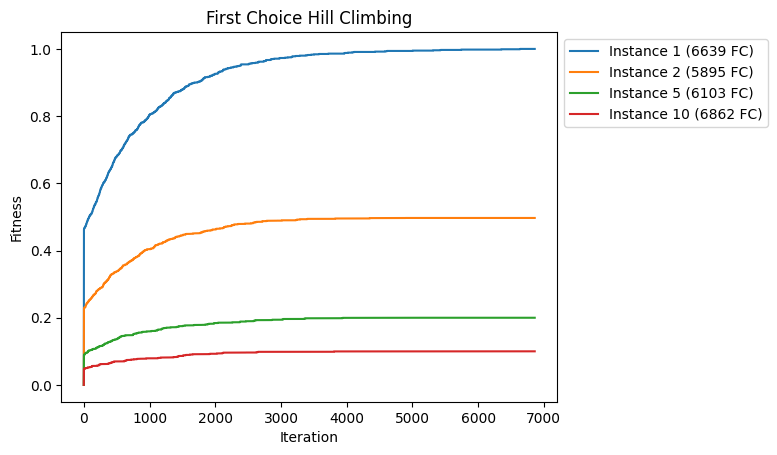

In [18]:
p_1 = lab9_lib.make_problem(1)
p_2 = lab9_lib.make_problem(2)
p_5 = lab9_lib.make_problem(5)
p_10 = lab9_lib.make_problem(10)


def neighbor(p:Individual, sample_size) -> Individual: 
    n = p.genome.copy()
    flip = sample(range(NUM_LOCI), sample_size)
    for f in flip:
        n[f] = 1 - n[f]
    return Individual(n)

def hill_climbing(fitness, distance=int(NUM_LOCI/2), max_wait=1000):
    current = Individual(choices([0, 1], k=NUM_LOCI))
    i = 0
    last_improvement = 0
    fitness_plot = [0]
    while current.evaluate(fitness)!=1 and i < last_improvement + max_wait:
        next = neighbor(current, distance)                              
        if next.evaluate(fitness) > current.evaluate(fitness):
            current = next
            last_improvement = i
        i += 1
        fitness_plot.append(current.evaluate(fitness))
    return fitness_plot, fitness.calls


hc1, hc1c = hill_climbing(p_1, 1)
hc2, hc2c = hill_climbing(p_2, 1)
hc5, hc5c = hill_climbing(p_5, 1)
hc10, hc10c = hill_climbing(p_10, 1)
x_axis = range(max(len(hc1), len(hc2), len(hc5), len(hc10)))
for a in [hc1, hc2, hc5, hc10]:
    while len(a) < len(x_axis):
        a.append(a[-1])

plt.title("First Choice Hill Climbing")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.plot(x_axis, hc1, label = "Instance 1 ("+str(hc1c)+" FC)")
plt.plot(x_axis, hc2, label = "Instance 2 ("+str(hc2c)+" FC)")
plt.plot(x_axis, hc5, label = "Instance 5 ("+str(hc5c)+" FC)")
plt.plot(x_axis, hc10, label = "Instance 10 ("+str(hc10c)+" FC)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

This approach requires a larger number of fitness calls but it seems to yield better results than the EA.

### Simulated Annealing
Let's try using Simulated Annealing, this algorithm tries to avoid local minima while trying to minimize a function by allowing "bad" moves with probability that decreases at each iteration, we can turn it into a maximizing algorithm simply by changing the sign of the delta.

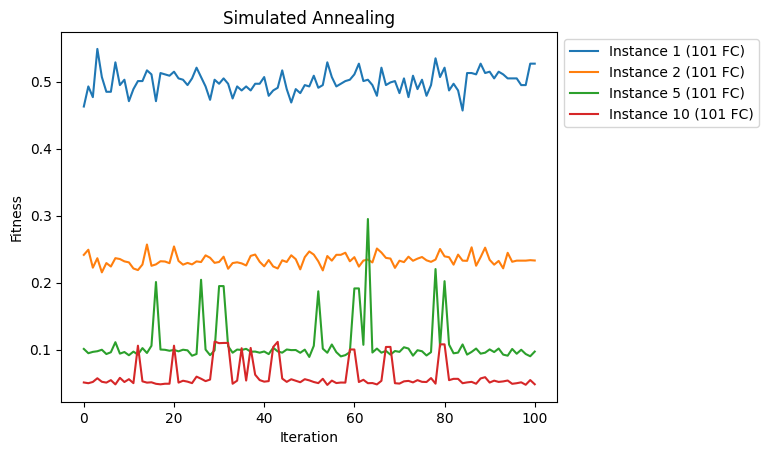

In [26]:
p_1 = lab9_lib.make_problem(1)
p_2 = lab9_lib.make_problem(2)
p_5 = lab9_lib.make_problem(5)
p_10 = lab9_lib.make_problem(10)




def simulated_annealing(fitness, distance=int(NUM_LOCI/2), cooling=0.01):
    current = Individual(choices([0, 1], k=NUM_LOCI))
    fitness_plot = [current.evaluate(fitness)]
    t = 1
    while t > 0:
        next = neighbor(current, distance)
        delta = next.evaluate(fitness) - current.evaluate(fitness)
        if delta > 0:
            current = next
        elif random() < exp(delta/t):
            current = next
        fitness_plot.append(current.evaluate(fitness))
        t = t - cooling
    return fitness_plot, fitness.calls


sa1, sa1c = simulated_annealing(p_1)
sa2, sa2c = simulated_annealing(p_2)
sa5, sa5c = simulated_annealing(p_5)
sa10, sa10c = simulated_annealing(p_10)
x_axis = range(len(sa1))

plt.title("Simulated Annealing")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.plot(x_axis, sa1, label = "Instance 1 ("+str(sa1c)+" FC)")
plt.plot(x_axis, sa2, label = "Instance 2 ("+str(sa2c)+" FC)")
plt.plot(x_axis, sa5, label = "Instance 5 ("+str(sa5c)+" FC)")
plt.plot(x_axis, sa10, label = "Instance 10 ("+str(sa10c)+" FC)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()




This algorithm seems to be the "cheapest" so far, requiring a low amount of fitness calls to reach similar results as the EA.
Let's now compare the algorithms tried so far using a scatter plot

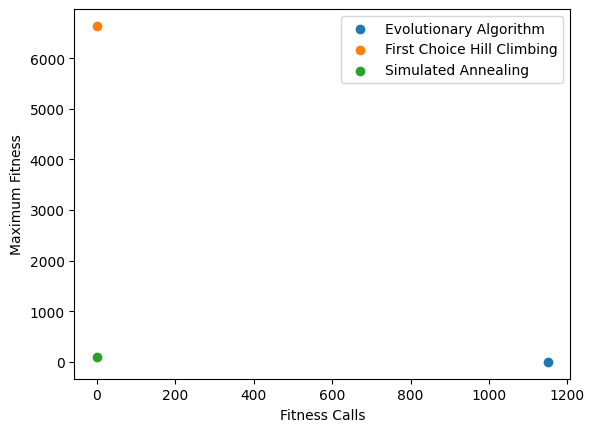

In [45]:
fig, ax = plt.subplots()
eas = [max(ea1), max(ea2), max(ea5), max(ea10)]
eacs = [ea1c, ea2c, ea5c, ea10c]
hcs = [max(hc1), max(hc2), max(hc5), max(hc10)]
hccs = [hc1c, hc2c, hc5c, hc10c]
sas = [max(sa1), max(sa2), max(sa5), max(sa10)]
sacs = [sa1c, sa2c, sa5c, sa10c]
   
eag = ax.scatter(eacs[0], eas[0], label='Evolutionary Algorithm')
hcg = ax.scatter(hcs[0], hccs[0], label='First Choice Hill Climbing')
sag = ax.scatter(sas[0], sacs[0], label='Simulated Annealing')
ax.set(xlabel='Fitness Calls', ylabel='Maximum Fitness')
ax.legend()

def update(frame):
    eag = ax.scatter(eacs[frame], eas[frame], label='Evolutionary Algorithm')
    hcg = ax.scatter(hcs[frame], hccs[frame], label='First Choice Hill Climbing')
    sag = ax.scatter(sas[frame], sacs[frame], label='Simulated Annealing')
    ax.legend()
    return (eag, hcg, sag)

ani = animation.FuncAnimation(fig=fig, func=update, frames=4, interval=1000)
plt.show()

In Instances 1 and 2 Simulated Annealing performs very well compared to the EA, reaching almost the same result in a tenth of the fitness calls, in instances 5 and 10 though, the results of Simulated Annealing are much worse, so in these cases we should still prefer the EA.

### Heuristic Reasoning
Let's now try to use some heuristic to find the solution, we don't have knowledge of the problem so we have to make some assumptions and see if the results confirm our hypothesis.
Let's assume that the genes are independant from each other, that means that the fitness is calculated as a linearly independant function of the genes:
$$fitness = \sum_{i=0}^{n\_genes} w_i \cdot g_i$$
Where $w_i$ is some weight assigned to the gene and $g_i$ is the binary value of the gene.
If this assumption holds true we should be able to find the best solution in at most $n\_genes+2$ fitness calls by following this simple procedure:
- Define an individual with all genes set to 0, this is our initial state;
- At each step we check if setting the gene $i$ to 1 improves upon our solution, if so we keep the gene and the new individual becomes the best solution otherwise we discard the gene;
- We stop until we reach maximum fitness or when all the genes have been tested.

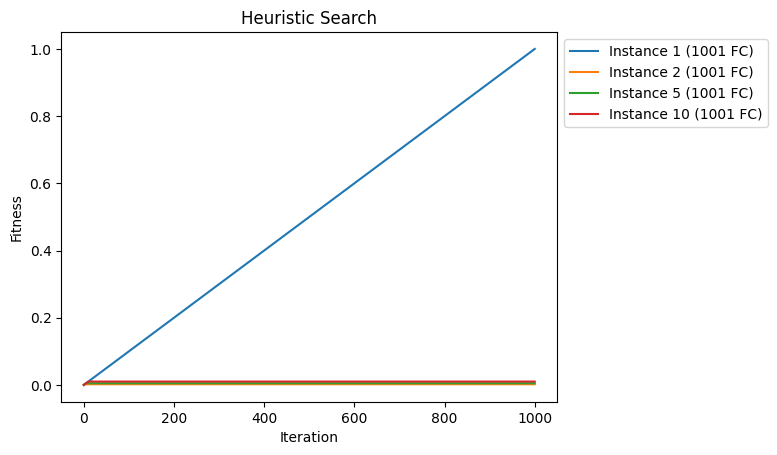

In [108]:
p_1 = lab9_lib.make_problem(1)
p_2 = lab9_lib.make_problem(2)
p_5 = lab9_lib.make_problem(5)
p_10 = lab9_lib.make_problem(10)


def heur_search(fitness):
    solution = Individual([0] * NUM_LOCI)   #start with all genes set to 0
    fitness_plot = [solution.evaluate(fitness)]
    for i in range(NUM_LOCI):
        gene = solution.genome.copy()
        gene[i] = 1
        next = Individual(gene)
        if next.evaluate(fitness) - solution.evaluate(fitness) > 0:
            solution = next
        fitness_plot.append(solution.evaluate(fitness))
        if solution.evaluate(fitness) == 1:
            break
    return fitness_plot, fitness.calls

h1, h1c = heur_search(p_1)
h2, h2c = heur_search(p_2)
h5, h5c = heur_search(p_5)
h10, h10c = heur_search(p_10)
x_axis = range(max(len(h1), len(h2), len(h5), len(h10)))
for a in [h1, h2, h5, h10]:
    while len(a) < len(x_axis):
        a.append(a[-1])

plt.title("Heuristic Search")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.plot(x_axis, h1, label = "Instance 1 ("+str(h1c)+" FC)")
plt.plot(x_axis, h2, label = "Instance 2 ("+str(h2c)+" FC)")
plt.plot(x_axis, h5, label = "Instance 5 ("+str(h5c)+" FC)")
plt.plot(x_axis, h10, label = "Instance 10 ("+str(h10c)+" FC)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()






For Instance 1 the problem is solved, our algorithm is able to find the best solution in 1001 steps, however for the other instances the problem doesn't seem to be solvable with such a simple approach, this means that we can assume linear independancy of the genes only for Instance 1.

10715086071862673209484250490600018105614048117055336074437503883703510511249361224931983788156958581275946729175531468251871452856923140435984577574698574803934567774824230985421074605062371141877954182153046474983581941267398767559165543946077062914571196477686542167660429831652624386837205668069376
